In [34]:
from importlib import reload
from datetime import datetime
import re

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf

from fbprophet import Prophet

import utils
reload(utils)

<module 'utils' from '/Users/andreanonali/Documents/DataScienceForBusiness/utils.py'>

In [2]:
ceased_labours = pd.read_csv('Rapporti_di_lavoro_cessati.csv')
ceased_labours.head()

,DATA,GENERE,ETA,SETTOREECONOMICODETTAGLIO,TITOLOSTUDIO,CONTRATTO,MODALITALAVORO,PROVINCIAIMPRESA,ITALIANO
0,02/04/2019,M,20,Lavori di meccanica generale,DIPLOMA DI ISTRUZIONE SECONDARIA SUPERIORE CH...,APPRENDISTATO PROFESSIONALIZZANTE O CONTRATTO ...,TEMPO PIENO,BERGAMO,ITALIA
1,08/06/2018,F,28,Fabbricazione di altre apparecchiature elettri...,DIPLOMA DI ISTRUZIONE SECONDARIA SUPERIORE CH...,APPRENDISTATO PROFESSIONALIZZANTE O CONTRATTO ...,TEMPO PIENO,BERGAMO,ITALIA
2,02/02/2016,F,20,Fabbricazione di altre apparecchiature elettri...,DIPLOMA DI ISTRUZIONE SECONDARIA SUPERIORE CH...,APPRENDISTATO PROFESSIONALIZZANTE O CONTRATTO ...,TEMPO PIENO,BERGAMO,ITALIA
3,12/01/2015,M,59,"Gestioni di funicolari, ski-lift e seggiovie s...",LICENZA MEDIA,LAVORO A TEMPO DETERMINATO,TEMPO PIENO,BERGAMO,ITALIA
4,09/08/2017,M,61,"Gestioni di funicolari, ski-lift e seggiovie s...",LICENZA MEDIA,LAVORO A TEMPO DETERMINATO,TEMPO PIENO,BERGAMO,ITALIA


# Transformations

In [3]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
one_hot_encoder = OneHotEncoder()
label_encoder = LabelEncoder()

In [4]:
ceased_transformed = pd.DataFrame()

##### GENERE -> dummies

In [5]:
df_col = ceased_labours['GENERE'].values.reshape(-1,1)
df_col

array([['M'],
       ['F'],
       ['F'],
       ...,
       ['M'],
       ['M'],
       ['M']], dtype=object)

In [6]:
X = one_hot_encoder.fit_transform(df_col).toarray()

In [7]:
ceased_transformed = pd.concat(
    [ceased_transformed, pd.DataFrame(X, columns=['GENERE_F', 'GENERE_M'])],
    axis=1
)
ceased_transformed.head()

,GENERE_F,GENERE_M
0,0.0,1.0
1,1.0,0.0
2,1.0,0.0
3,0.0,1.0
4,0.0,1.0


##### TITOLO STUDIO -> custom transformation
following this ordinal rules [ISTAT document](https://www.istat.it/it/files/2011/01/Classificazione-titoli-studio-28_ott_2005-nota_metodologica.pdf)

In [8]:
ceased_labours.TITOLOSTUDIO.unique()

array(["DIPLOMA DI ISTRUZIONE SECONDARIA SUPERIORE  CHE PERMETTE L'ACCESSO ALL'UNIVERSITA",
       'LICENZA MEDIA',
       "TITOLO DI ISTRUZIONE SECONDARIA SUPERIORE (SCOLASTICA ED EXTRA-SCOLASTICA) CHE NON PERMETTE L'ACCESSO ALL'UNIVERSITÀ ()",
       'LICENZA ELEMENTARE', 'NESSUN TITOLO DI STUDIO',
       'LAUREA - Vecchio o nuovo ordinamento', 'DIPLOMA UNIVERSITARIO',
       'DIPLOMA DI SPECIALIZZAZIONE', 'TITOLO DI STUDIO POST-LAUREA',
       'TITOLO DI DOTTORE DI RICERCA',
       'MASTER UNIVERSITARIO DI PRIMO LIVELLO',
       'DIPLOMA TERZIARIO EXTRA-UNIVERSITARIO', nan], dtype=object)

In [9]:
mapper = {
    'NESSUN TITOLO DI STUDIO': 0,
    'LICENZA ELEMENTARE': 1,
    'LICENZA MEDIA': 2,
    'TITOLO DI ISTRUZIONE SECONDARIA SUPERIORE (SCOLASTICA ED EXTRA-SCOLASTICA) CHE NON PERMETTE L\'ACCESSO ALL\'UNIVERSITÀ ()': 3,
    'DIPLOMA DI ISTRUZIONE SECONDARIA SUPERIORE  CHE PERMETTE L\'ACCESSO ALL\'UNIVERSITA': 4,
    'DIPLOMA TERZIARIO EXTRA-UNIVERSITARIO': 5,
    'DIPLOMA UNIVERSITARIO': 6,
    'LAUREA - Vecchio o nuovo ordinamento': 7,
    'MASTER UNIVERSITARIO DI PRIMO LIVELLO': 8,
    'DIPLOMA DI SPECIALIZZAZIONE': 9,
    'TITOLO DI DOTTORE DI RICERCA': 10,
    'TITOLO DI STUDIO POST-LAUREA': 11
}
ceased_transformed['TITOLOSTUDIO'] = ceased_labours['TITOLOSTUDIO'].replace(mapper)
ceased_transformed.head()

,GENERE_F,GENERE_M,TITOLOSTUDIO
0,0.0,1.0,4.0
1,1.0,0.0,4.0
2,1.0,0.0,4.0
3,0.0,1.0,2.0
4,0.0,1.0,2.0


In [10]:
ceased_transformed.TITOLOSTUDIO.unique()

array([ 4.,  2.,  3.,  1.,  0.,  7.,  6.,  9., 11., 10.,  8.,  5., nan])

##### TODO: inspect why missing values are introduced

In [11]:
utils.missing_values_table(ceased_transformed)

Your selected dataframe has 3 columns.
There are 1 columns that have missing values.


,Missing Values,% of Total Values
TITOLOSTUDIO,440,0.0


##### MODALITÀ LAVORO -> LabelEncoder

In [12]:
ceased_labours.MODALITALAVORO.unique()

array(['TEMPO PIENO', 'NON DEFINITO', 'TEMPO PARZIALE ORIZZONTALE',
       'TEMPO PARZIALE VERTICALE', 'TEMPO PARZIALE MISTO'], dtype=object)

In [13]:
ceased_transformed['MODALITALAVORO'] = label_encoder.fit_transform(ceased_labours.MODALITALAVORO)
ceased_transformed.head()

,GENERE_F,GENERE_M,TITOLOSTUDIO,MODALITALAVORO
0,0.0,1.0,4.0,4
1,1.0,0.0,4.0,4
2,1.0,0.0,4.0,4
3,0.0,1.0,2.0,4
4,0.0,1.0,2.0,4


In [14]:
ceased_transformed.MODALITALAVORO.unique()

array([4, 0, 2, 3, 1])

# Time Analysis

In [15]:
timed_labours = ceased_labours.copy()

##### Convert 'DATA' column into datetime field

Control the format

In [16]:
r = re.compile(r'[0-9][0-9]\/[0-9][0-9]\/[0-9][0-9][0-9][0-9]')
regmatch = np.vectorize(lambda x: bool(r.match(x)))

matches = regmatch(timed_labours.DATA.values)
if np.count_nonzero(matches) == len(timed_labours.DATA):
    print("All the values in the data columns matches the pattern")
else:
    raise Exception("ERROR: not all the values in the data columns matches the pattern")

All the values in the data columns matches the pattern


Convert the data

In [17]:
timed_labours.DATA= timed_labours.DATA.apply(
    lambda date_str: datetime.strptime(date_str, "%d/%m/%Y")
)

In [18]:
timed_labours.DATA.head()

0    2019-04-02 00:00:00
1    2018-06-08 00:00:00
2    2016-02-02 00:00:00
3    2015-01-12 00:00:00
4    2017-08-09 00:00:00
Name: DATA, dtype: object

In [19]:
timed_labours.dtypes

DATA                         object
GENERE                       object
ETA                           int64
SETTOREECONOMICODETTAGLIO    object
TITOLOSTUDIO                 object
CONTRATTO                    object
MODALITALAVORO               object
PROVINCIAIMPRESA             object
ITALIANO                     object
dtype: object

Sort by date

In [20]:
utils.sort_by(timed_labours, 'DATA')

Sorted


Create the month and year columns

In [21]:
timed_labours['MONTH'] = timed_labours.DATA.apply(lambda _date: _date.month)

In [22]:
timed_labours['YEAR'] = timed_labours.DATA.apply(lambda _date: _date.year)

Set the DATA columns as the index

In [23]:
timed_labours.set_index('DATA', inplace=True)

Distribution of ceased labours in all years by month

In [24]:
monthly_count = timed_labours.groupby(timed_labours.MONTH).count().iloc[:, [0]]
monthly_count.rename(columns={'GENERE': 'COUNT'}, inplace=True)
monthly_count

,COUNT
MONTH,
1,441157
2,478865
3,437763
4,409512
5,327649
6,226276
7,231928
8,218792
9,237503


<AxesSubplot:title={'center':'Ceased labours for every month of each year'}, xlabel='months', ylabel='counts'>

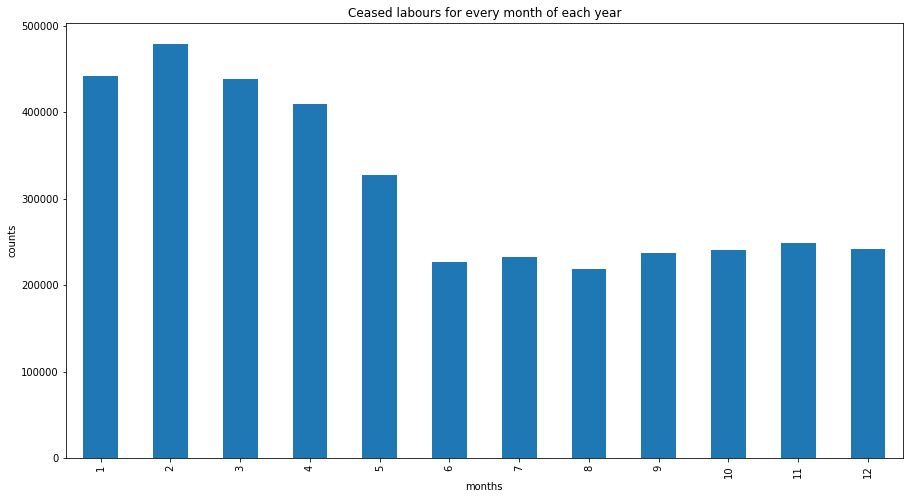

In [25]:
monthly_count.plot(
    title='Ceased labours for every month of each year',
    xlabel='months',
    ylabel='counts',
    kind='bar',
    legend=False,
    figsize=(15, 8)
)

##### Analyze the time series

In [26]:
timed_labours2 = timed_labours[['GENERE']]

In [27]:
timed_labours2.index = pd.to_datetime(timed_labours2.index, errors='coerce')

In [28]:
timed_labours2 = timed_labours2.resample('M').count()
timed_labours2.rename(columns={'GENERE': 'COUNT'}, inplace=True)

In [29]:
# filter data that are too low
timed_labours2 = timed_labours2[timed_labours2.COUNT > 5000]

<AxesSubplot:xlabel='DATA'>

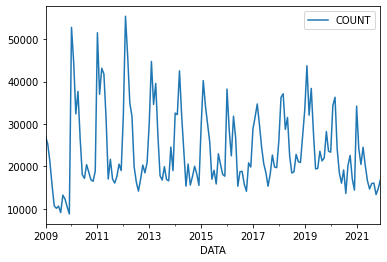

In [30]:
timed_labours2.plot()

We can see that the count of activated labours tends to decrease during 2020 and 2021, conurrently to the covid period.

Autocorrelation

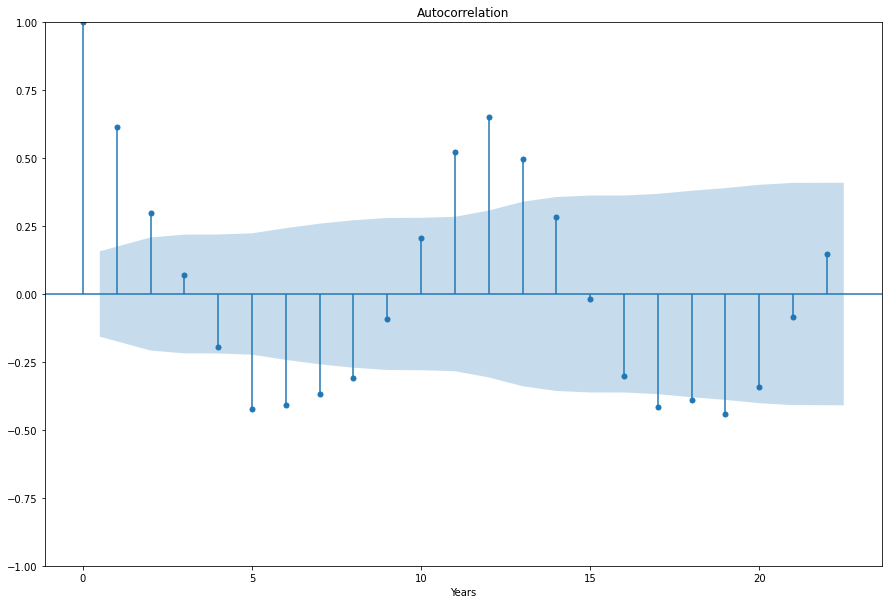

In [31]:
plt.rc('figure', figsize=(15, 10))
plot_acf(timed_labours2)
plt.xlabel('Years')
plt.show()

There is a little correlation during the first day of the months

# Prophet time series forecasting

Our research question is to predict wether 2022 will be a year in which people are more likely not to quit their job, looking for stability in the period after the covid 19 pandemic.

In [35]:
timed_labours2.columns

Index(['COUNT'], dtype='object')

In [36]:
X, y = utils.create_prophet_features(timed_labours2, label='COUNT')

features_and_target = pd.concat([X, y], axis=1)

print("Shape",features_and_target.shape)
features_and_target.head(10)

Shape (156, 9)


/Users/andreanonali/Documents/DataScienceForBusiness/utils.py:102: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df['weekofyear'] = df['date'].dt.weekofyear


,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,COUNT
DATA,,,,,,,,,
2009-01-31,0,5,1,1,2009,31,31,5,26988
2009-02-28,0,5,1,2,2009,59,28,9,25331
2009-03-31,0,1,1,3,2009,90,31,14,21136
2009-04-30,0,3,2,4,2009,120,30,18,15604
2009-05-31,0,6,2,5,2009,151,31,22,10741
2009-06-30,0,1,2,6,2009,181,30,27,10147
2009-07-31,0,4,3,7,2009,212,31,31,10658
2009-08-31,0,0,3,8,2009,243,31,36,9140
2009-09-30,0,2,3,9,2009,273,30,40,13256


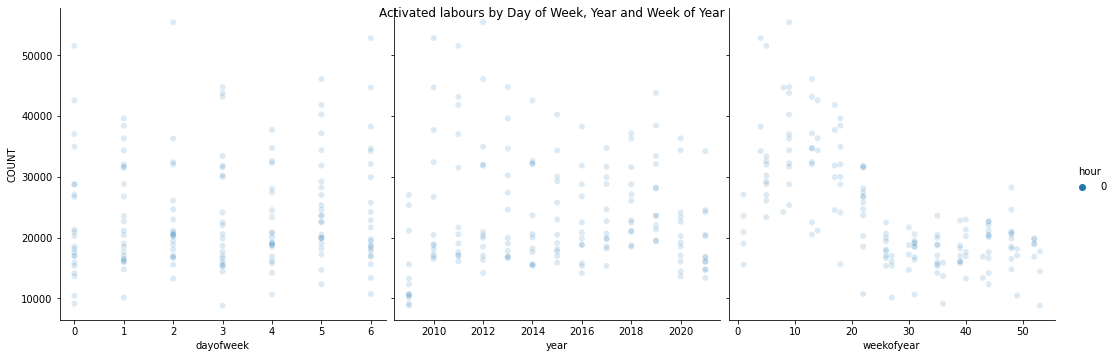

In [37]:
sns.pairplot(features_and_target.dropna(),
             hue='hour',
             x_vars=['dayofweek',
                     'year','weekofyear'],
             y_vars='COUNT',
             height=5,
             plot_kws={'alpha':0.15, 'linewidth':0}
            )
plt.suptitle('Activated labours by Day of Week, Year and Week of Year')
plt.show()

In [38]:
split_date = '01-Jan-2018'
timed_labours_train = timed_labours2.loc[timed_labours2.index <= split_date].copy()
timed_labours_test = timed_labours2.loc[timed_labours2.index > split_date].copy()

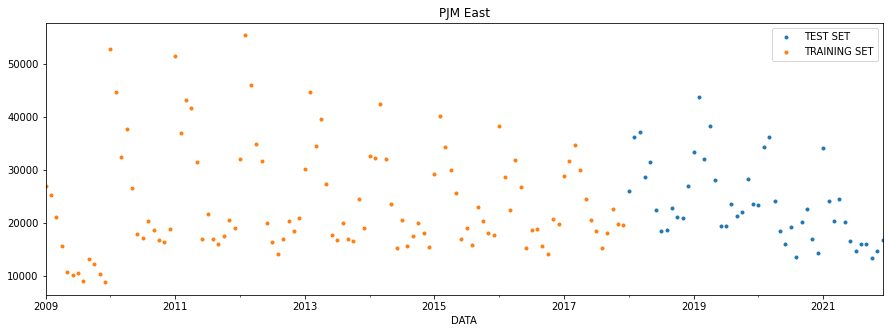

In [39]:
# Plot train and test so you can see where we have split
timed_labours_test \
    .rename(columns={'COUNT': 'TEST SET'}) \
    .join(timed_labours_train.rename(columns={'COUNT': 'TRAINING SET'}),
          how='outer') \
    .plot(figsize=(15,5), title='PJM East', style='.')
plt.show()

In [40]:
# Format data for prophet model using ds and y
timed_labours_train.reset_index() \
    .rename(columns={'DATA':'ds',
                     'COUNT':'y'})

print(timed_labours_train.columns)
timed_labours_train.head(5)

Index(['COUNT'], dtype='object')


,COUNT
DATA,
2009-01-31,26988
2009-02-28,25331
2009-03-31,21136
2009-04-30,15604
2009-05-31,10741


In [41]:
model = Prophet()
model.fit(timed_labours_train.reset_index() \
              .rename(columns={'DATA':'ds',
                               'COUNT':'y'}))

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -3.84155


/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       194.207   0.000125392       71.8583           1           1      137   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     139       194.234   2.02332e-06       69.9333   3.382e-08       0.001      227  LS failed, Hessian reset 
     199       194.245   9.55584e-06       69.2508           1           1      310   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     204       194.246   1.21189e-05       70.0204   1.664e-07       0.001      355  LS failed, Hessian reset 
     299       194.257   5.45028e-07       75.0817      0.3119           1      488   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       195.662   0.000101748        69.324      0.4008           1      608   
    Iter      log prob        ||dx||      ||grad||       alpha

In [42]:
# Predict on training set with model
timed_labours_test_fcst = model.predict(df=timed_labours_test.reset_index().rename(columns={'DATA':'ds'}))

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


In [43]:
timed_labours_test_fcst.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2018-01-31,23769.552066,28770.082499,41315.735534,23769.507860,23769.876623,11360.196728,11360.196728,11360.196728,11360.196728,11360.196728,11360.196728,0.0,0.0,0.0,35129.748794
1,2018-02-28,23737.846430,30417.125582,43047.297460,23734.121542,23743.805174,13135.757301,13135.757301,13135.757301,13135.757301,13135.757301,13135.757301,0.0,0.0,0.0,36873.603731
2,2018-03-31,23702.743762,28338.689905,41130.609689,23692.688470,23717.398603,10555.419133,10555.419133,10555.419133,10555.419133,10555.419133,10555.419133,0.0,0.0,0.0,34258.162895
3,2018-04-30,23668.773438,25545.679324,38340.484330,23650.504737,23692.265516,8411.719344,8411.719344,8411.719344,8411.719344,8411.719344,8411.719344,0.0,0.0,0.0,32080.492782
4,2018-05-31,23633.670770,17947.001017,30840.164538,23605.926970,23668.381552,1004.775265,1004.775265,1004.775265,1004.775265,1004.775265,1004.775265,0.0,0.0,0.0,24638.446035


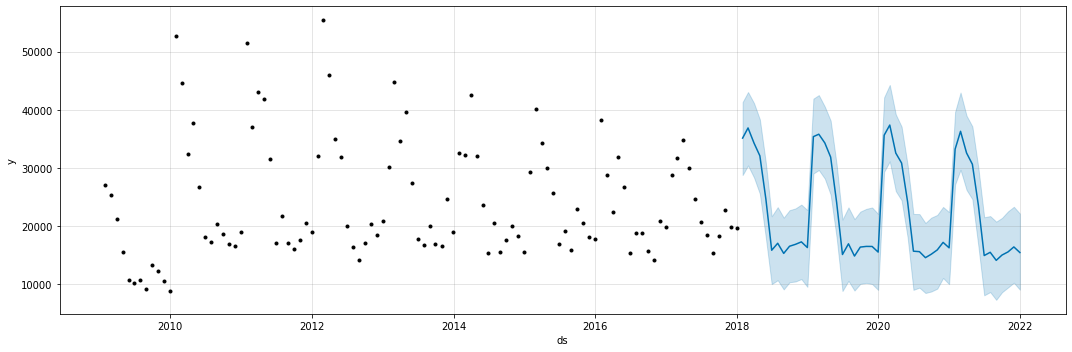

In [44]:
# Plot the forecast
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
fig = model.plot(timed_labours_test_fcst,
                 ax=ax)
plt.show()

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


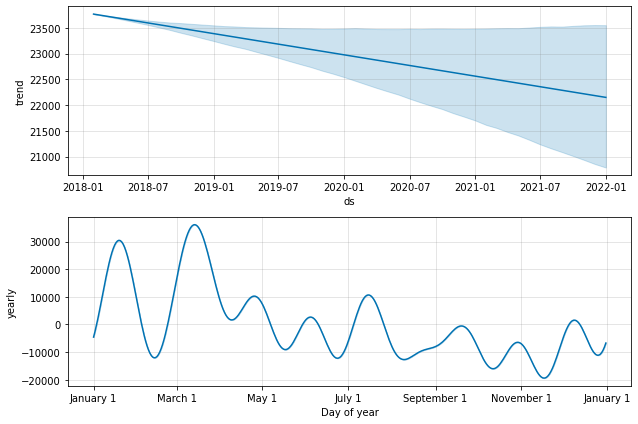

In [45]:
# Plot the components of the model
fig = model.plot_components(timed_labours_test_fcst)